# Boundary behaviour tutorial
In many parcels simulations particles end up moving onto parts of the grid where the velocity field is not defined because it is part of a solid. Particles drifting on a model surface ocean move onto land cells for example. In this tutorial we look at how this happens in different velocity fields. Based on this we showcase some options on how to treat the particles that leave the model domain across these solid-fluid boundaries.

The tutorial first looks at how velocity fields are structured and what that means for where the solid-fluid boundaries are located. Then we will look at the different options to manage particle behaviour at the boundaries. 
<!-- Finally we benchmark the different options to assess the qualities of the different options. -->

* [Velocity fields](#Velocity-fields)
    * [A grids](#A-grids)
    * [C grids](#C-grids)
* [Boundary solutions](#Boundary-solutions)
    * [Plain parcels output](#Plain-parcels)
    * [Flag on land](#Flag-on-land-cells)
    * [Parabolic profile](#Parabolic-profile)
    * [Nudging current](#Nudging-steps)
    * [Stochastic beaching](#Stochastic-beaching)
<!-- * [Benchmarking](#Benchmarking) -->
* [References](#References)

In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, Variable, Field

import numpy as np
import xarray as xr
from datetime import timedelta as delta
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from copy import copy
from scipy import interpolate
import os

def _check_file_exist(File: str): return os.path.isfile(File)

## Velocity fields
The velocity fields used to advect particles in Parcels may come from different types of models. Model boundaries are defined at the moment Boundary Conditions are introduced in a numerical problem or sometimes when an analytical solution is discretised onto a numerical grid. To correctly simulate the Lagrangian trajectory near any solid-fluid boundary it is important to understand two things:
1. Whether and how a model permits fluid trajectories to cross the model boundary
2. How the Boundary Conditions can affect the location of the boundary relative to the known velocity grid.

### Crossing model boundaries
Many ocean models are mass-conserving, meaning that the boundary conditions are formulated in such a way that the entire fluid stays inside the model domain: the boundary conditions usually state that the velocity component normal to the boundary is zero at the boundary. If this type of velocity field is used as input for parcels, we should expect that only numerical errors can lead to particle trajectories crossing the model boundary. 

In some cases however, the velocity field permits cross-boundary flow. An example of this is the wind-stress field that causes the Stokes drift of particles. The wind field does not necessarily care about the model domain and can push particles onto the coast. Another example may be a very high-resolution fluid model in which permeable boundaries exist. This tutorial is mainly focussed on velocity fields that are mass-conserving within the parcels domain. If the velocity field consists of multiple components, like currents and Stokes drift, some of the solutions in tutorial may be applicable only to the mass-conserving field, while others affect both fields.

### Location of the boundary - consequences for Parcels

The velocity field that you pass into the parcels framework using [`parcels.FieldSet`](https://oceanparcels.org/gh-pages/html/#module-parcels.fieldset) only consists of the velocity data and the coordinates of the grid points in physical space. The only boundaries that parcels "sees" are grid points at which the velocity vector is zero. Because of the bilinear interpolation that parcels uses in the entire domain, the particle velocity only goes to zero when the four (2D) or eight (3D) nearest velocity vectors are zero. The model boundary is not necessarily defined at the grid points where the velocity is zero. Here we take a look at two common model grids and the consequences of some common boundary conditions for parcels trajectories.

#### A grids
Arakawa A grids are unstaggered grids where the velocities u, v (and w), pressure and other tracers are defined at the same position. These nodes can be located **at the center or the edges of the grid cells**. This means that the cell boundaries, and therefore the solid-fluid boundaries can either be located between the nodes or at the nodes respectively (see figure below). Where the nodes are positioned with respect to the boundaries is determined by the type of Boundary Condition. Nodes are at cell corners when using a [Dirichlet boundary condition](https://en.wikipedia.org/wiki/Dirichlet_boundary_condition) where the values of one or multiple variables are defined at the boundary. On the other hand, when a [Neumann boundary condition](https://en.wikipedia.org/wiki/Neumann_boundary_condition) is imposed, which specifies the derivative of a variable at the boundary, the nodes may be placed at the center of grid cells which allows the derivative to be formulated more precisely at the boundary.

Assuming that the most often used boundary condition in fluid dynamics models states that the normal-component of the velocity goes to zero at the boundary we can conclude that usually a Dirichlet boundary condition is used and the nodes are positioned at the corners of cells (**figure 1A** below). This is compatible with the way in which parcels interpolates A grids: The particle velocity is interpolated from the four surrounding nodes, which means that when a particle enters a solid grid cell the four surrounding nodes are all zero and the particle is stuck on land or 'beached'. To improve the parcels simulation we should be able to implement the boundary condition in Parcels (see [Parabolic profile](#Parabolic-profile)).

There are two important exceptions to the case where Dirichlet boundary conditions are implemented in this way. The first is when an **analytical solution is discretised onto a numerical grid**. This is done in [example_peninsula.py](https://github.com/OceanParcels/parcels/blob/master/parcels/examples/example_peninsula.py). In this case the boundary is located at an exact curve between the nearest solid and fluid nodes. To implement the correct boundary conditions in this case is very hard I imagine.

The other exception is likely to occur more often. Many ocean models are run on a C grid, because boundary conditions are more straightforward to implement there (see [C grid](#C-grids)). **Often the C-grid output of these models is interpolated onto an A grid**. Since the pressure and tracers are defined at the center of grid cells in a C grid, I suspect the velocities to be interpolated onto these centers as well. This seems the easiest way to define all variables at the same position. This interpolation is also done in [in parcels](https://gmd.copernicus.org/articles/12/3571/2019/#bib1.bibx10) for C grids. In this case, the boundaries are located in between nodes (see **figure B**). This would mean that a particle in parcels can be in a solid grid cell and be incorrectly advected. Note how the boundary condition is indeed imposed at the cell boundary in a [C grid](#C-grids). This again has consequences for the corrections we should make. 

In [2]:
Peninsula_file = 'Peninsula_data/peninsulaU.nc'
flowdata = xr.open_dataset(Peninsula_file)

dx = flowdata['x'][1]-flowdata['x'][0]
dy = flowdata['y'][1]-flowdata['y'][0]
x_corners, y_corners = np.meshgrid(np.arange(flowdata['x'].values[0]-0.5*dx, flowdata['x'].values[-1]+1.5*dx, dx),
                np.arange(flowdata['y'].values[0]-0.5*dy, flowdata['y'].values[-1]+0.5*dy, dy))
x_centers, y_centers = np.meshgrid(np.arange(flowdata['x'].values[0], flowdata['x'].values[-1]+dx, dx),
                np.arange(flowdata['y'].values[0], flowdata['y'].values[-1], dy))
cells = np.zeros((len(flowdata['y'])-1,len(flowdata['x'])-1))

### Create seethrough colormap to show different grid interpretations
cmap = plt.get_cmap('Blues')
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = 0
my_cmap = ListedColormap(my_cmap)

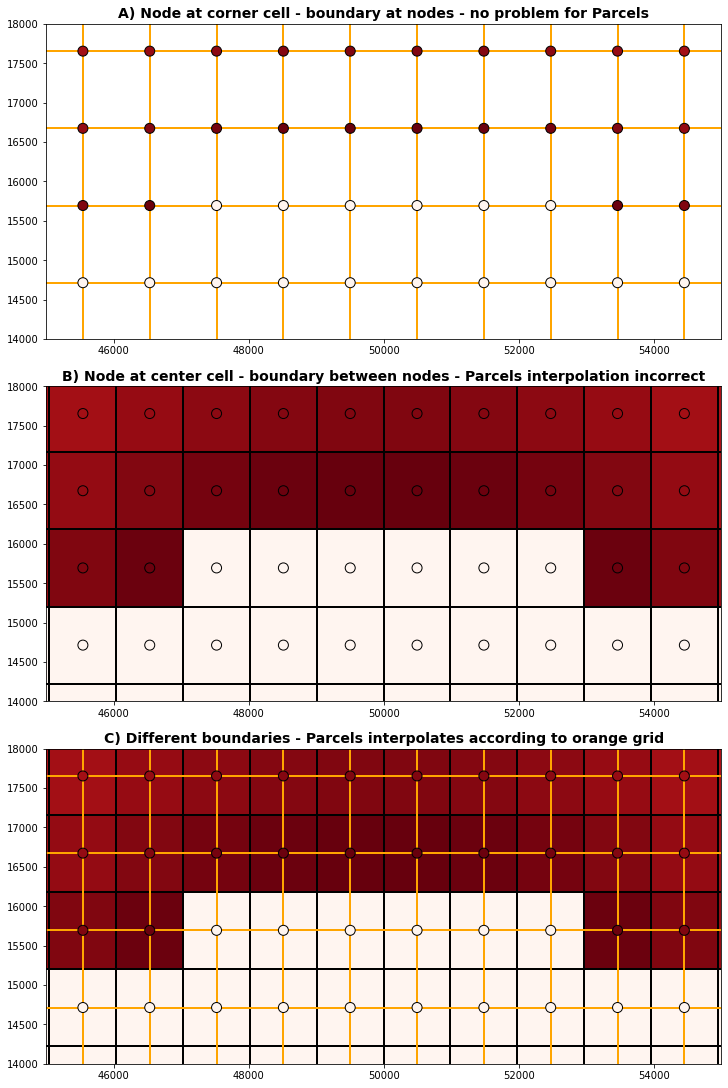

In [3]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,15),constrained_layout=True)

ax1.set_xlim(45000, 55000)
ax1.set_ylim(14000, 18000)
ax1.set_title('A) Node at corner cell - boundary at nodes - no problem for Parcels', fontsize=14, fontweight = 'bold')
ax1.pcolormesh(x_centers,y_centers,cells,cmap=my_cmap,edgecolors='orange')
ax1.scatter(x_centers,y_centers,s=100,c=flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k')

ax2.set_xlim(45000, 55000)
ax2.set_ylim(14000, 18000)
ax2.set_title('B) Node at center cell - boundary between nodes - Parcels interpolation incorrect', fontsize=14, fontweight = 'bold')
ax2.pcolormesh(x_corners,y_corners,flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k',linewidth=1)
ax2.scatter(x_centers,y_centers,s=100,c=flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k')

ax3.set_xlim(45000, 55000)
ax3.set_ylim(14000, 18000)
ax3.set_title('C) Different boundaries - Parcels interpolates according to orange grid', fontsize=14, fontweight = 'bold')
ax3.pcolormesh(x_corners,y_corners,flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k',linewidth=1)
ax3.pcolormesh(x_centers,y_centers,cells,cmap=my_cmap,edgecolors='orange')
ax3.scatter(x_centers,y_centers,s=100,c=flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k')

## For now we look at three cases: the discretised analytical solution in the Peninsula data, SMOC data and C-grid NEMO data

### Analytical solution discretized
The following demonstrates particles getting stuck on the model domain of an analytical solution discretised onto an A grid. Particles are released along a line that crosses the boundary. 

In [4]:
fieldset = FieldSet.from_parcels("Peninsula_data/peninsula", allow_time_extrapolation=True)

npart = 5  # number of particles to be released
lon = 4e4 * np.ones(npart)
lat = np.linspace(11.6e3 , 13e3, npart, dtype=np.float32)
time = np.zeros(npart)

pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon, lat=lat, time=time)

output_file = pset.ParticleFile(name="Agrid-stuck.nc", outputdt=delta(minutes=5))
pset.execute(AdvectionRK4, runtime=delta(hours=12), dt=delta(minutes=5),
             output_file=output_file)
output_file.close()  # export the trajectory data to a netcdf file

INFO: Compiled JITParticleAdvectionRK4 ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\55e359cbb3ccce619b0f5fe946a71849_0.dll


In [5]:
ds_peninsula = xr.open_dataset('Agrid-stuck.nc')

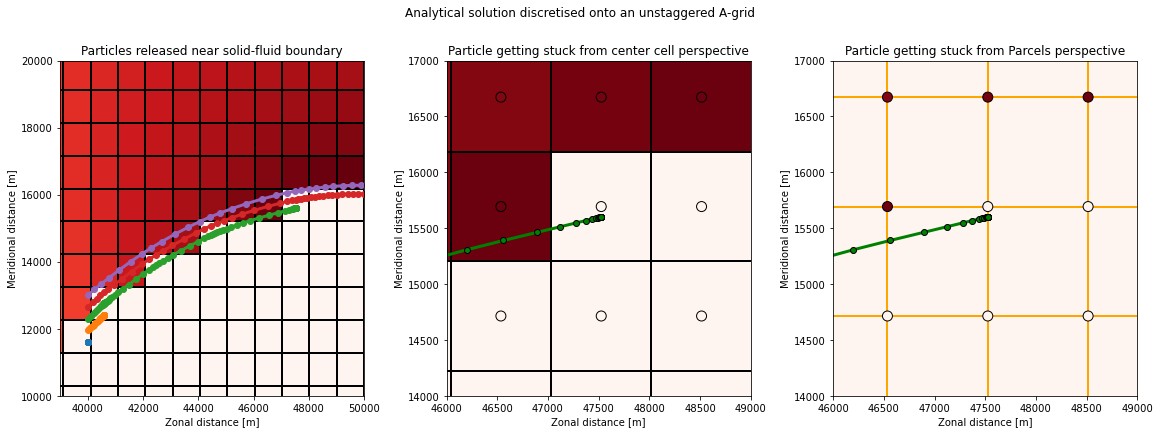

In [6]:
fig = plt.figure(figsize=(16,6), constrained_layout=True)
fig.suptitle('Analytical solution discretised onto an unstaggered A-grid')
gs = gridspec.GridSpec(ncols=3, nrows=2, height_ratios = [0.2,2], figure=fig)

ax1 = fig.add_subplot(gs[1, 0])
ax1.set_ylabel('Meridional distance [m]')
ax1.set_xlabel('Zonal distance [m]')
ax1.set_title('Particles released near solid-fluid boundary')
ax1.set_xlim(39000, 50000)
ax1.set_ylim(10000, 20000)

ax1.pcolormesh(x_corners,y_corners,flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k',linewidth=1)
ax1.plot(ds_peninsula['lon'].T, ds_peninsula['lat'].T,marker='o',linewidth=3)

ax2 = fig.add_subplot(gs[1, 1])
ax2.set_ylabel('Meridional distance [m]')
ax2.set_xlabel('Zonal distance [m]')
ax2.set_title('Particle getting stuck from center cell perspective')
ax2.set_xlim(46000, 49000)
ax2.set_ylim(14000, 17000)

ax2.pcolormesh(x_corners,y_corners,flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k',linewidth=1)
ax2.plot(ds_peninsula['lon'].sel(traj=2), ds_peninsula['lat'].sel(traj=2), c='g', linewidth=3, marker='o', markeredgecolor='k')
ax2.scatter(x_centers,y_centers,s=100,c=flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k')

ax3 = fig.add_subplot(gs[1, 2])
ax3.set_ylabel('Meridional distance [m]')
ax3.set_xlabel('Zonal distance [m]')
ax3.set_title('Particle getting stuck from Parcels perspective')
ax3.set_xlim(46000, 49000)
ax3.set_ylim(14000, 17000)

ax3.pcolormesh(x_centers,y_centers,cells,cmap='Reds',edgecolors='orange',linewidth=1)
ax3.scatter(x_centers,y_centers,s=100,c=flowdata['vozocrtx'][0,0],cmap='Reds', edgecolors='k')
ax3.plot(ds_peninsula['lon'].sel(traj=2), ds_peninsula['lat'].sel(traj=2), c='g', linewidth=3, marker='o', markeredgecolor='k')

Here we can see the two different ways we can perceive solid-fluid boundaries in an Arakawa A grid. When the velocities are defined at the center of grid cells, Parcels interpolates half a cell into the solid. If the velocity nodes are at the corners of the computational cell, Parcels interpolates correctly and when the timestep is sufficiently small, particles will not cross the solid-fluid boundary. Particles do however get stuck at the boundary since the linear interpolation does not turn the flow tangential to the boundary at a subgrid scale. Near physical solid-fluid boundaries the flow will become tangential to the boundary. In [staggered models](#C-grids) this can be achieved easily because Parcels naturally [introduces a partial-slip boundary](#C-grids). For Arakawa A grids we propose to make the velocity tangential near the boundaries by imposing different profiles for the normal and tangential velocity components.

### C grids

On staggered grids, different types of boundary conditions can be satisfied simultaneously. On a C-grid, the velocities are defined on the cell-edges normal to the velocity-component and pressure, temperature and tracers are defined at the cell centers. This way, the Dirichlet boundary condition can be used for the velocities, while the Neumann boundary condition can be satisfied for the gradient of pressure.

In NEMO (Documentation [here](https://www.nemo-ocean.eu/doc/node58.html)), the normal-component of velocity, defined at the cell faces where the boundary is defined, is set to zero at all boundaries. There are different options for the tangential velocity: a free-slip condition, a partial-slip condition and a no-slip condition. Since the tangential velocity is not defined at the boundary, this boundary condition relies on the two nodes at either side of the solid-fluid boundary: an implied "ghost" velocity is generated in the solid domain. The type of boundary condition defines the direction and magnitude of ths "ghost" velocity relative to the tangential velocity in the fluid domain. In Parcels, these "ghost" velocities are not generally included in a NEMO dataset. **Question: Parcels interpolates piecewise-constant in the y-direction for the U velocity and in the x-direction for the V velocity right? If so, this probably results in a free-slip condition as shown in 8.2a in the documentation** This scenario with no "ghost" velocity most closely resembles a partial-slip condition as defined in the [NEMO documentation](https://www.nemo-ocean.eu/doc/node58.html) (Figure 8.2c).

In [7]:
cufields = xr.open_dataset('NemoNorthSeaORCA025-N006_data/ORCA025-N06_20000104d05U.nc')
cvfields = xr.open_dataset('NemoNorthSeaORCA025-N006_data/ORCA025-N06_20000104d05V.nc')

xu_corners, yu_corners = np.meshgrid(np.arange(cufields['x'].values[0], cufields['x'].values[-1]+1, 1),
                np.arange(cufields['y'].values[0]-0.5, cufields['y'].values[-1]+0.5, 1))
xv_corners, yv_corners = np.meshgrid(np.arange(cvfields['x'].values[0]-0.5, cvfields['x'].values[-1]+0.5, 1),
                np.arange(cvfields['y'].values[0], cvfields['y'].values[-1]+1, 1))
cx_centers, cy_centers = np.meshgrid(np.arange(cvfields['x'].values[0]-0.5, cvfields['x'].values[-1]+1.5, 1),
                np.arange(cvfields['y'].values[0]-0.5, cvfields['y'].values[-1]+1.5, 1))
fx_corners, fy_corners = np.meshgrid(np.arange(cufields['x'].values[0]-1, cufields['x'].values[-1]+1, 1),
                np.arange(cufields['y'].values[0]-1, cufields['y'].values[-1]+1, 1))
c_cells = np.zeros((len(cufields['y']),len(cufields['x'])))

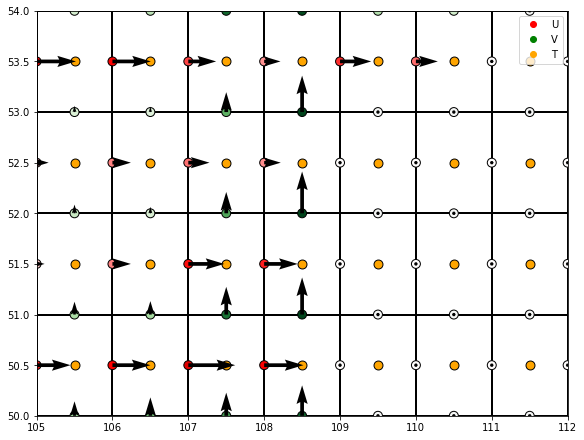

In [8]:
fig = plt.figure(figsize=(8,6),constrained_layout=True)
ax1=plt.axes()

ax1.set_xlim(105, 112)
ax1.set_ylim(50, 54)
ax1.pcolormesh(fx_corners,fy_corners,c_cells,cmap=my_cmap,edgecolors='k',linewidth=1)
ax1.scatter(xu_corners,yu_corners, s=80,c=cufields['uos'][0],cmap='seismic',vmin=-0.1,vmax=0.1,edgecolor='k', label = 'U')
ax1.scatter(xv_corners,yv_corners, s=80,c=cvfields['vos'][0],cmap='PRGn',vmin=-0.1,vmax=0.1,edgecolor='k', label = 'V')
ax1.scatter(cx_centers,cy_centers, s=80,c='orange',edgecolor='k', label = 'T')
ax1.quiver(xu_corners,yu_corners,cufields['uos'][0],np.zeros(xu_corners.shape),angles='xy', scale_units='xy', scale=0.1, width=0.007)
ax1.quiver(xv_corners,yv_corners,np.zeros(xv_corners.shape),cvfields['vos'][0],angles='xy', scale_units='xy', scale=0.3, width=0.007)

custom_lines = [Line2D([0], [0], marker='o', color='r',lw=0),
                Line2D([0], [0], marker='o', color='g', lw=0),
                Line2D([0], [0], marker='o', color='orange', lw=0)]

ax1.legend(custom_lines, ['U', 'V', 'T'],loc='upper right')

As we can see in the figure above, the standard NEMO velocity data does not include "ghost" velocities in the solid domain. The boundary is defined at the faces where the normal velocity is zero. The tangential velocity is not defined at the boundary. If the interpolation is piecewise-constant in the direction normal to the boundary, the tangential velocity at the boundary is the same as the tangential velocity in the last fluid cell: a free-slip boundary. If the interpolation is linear between the nodes at either side of the boundary there would be a smaller tangential velocity at the boundary: a partial-slip boundary.

In [9]:
from glob import glob

data_path = 'NemoNorthSeaORCA025-N006_data/'
ufiles = sorted(glob(data_path+'ORCA*U.nc'))
vfiles = sorted(glob(data_path+'ORCA*V.nc'))
wfiles = sorted(glob(data_path+'ORCA*W.nc'))
mesh_mask = data_path + 'coordinates.nc'

coords = xr.open_dataset(mesh_mask, decode_times=False)

In [10]:
filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': ufiles},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': vfiles},
             'W': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': wfiles[0], 'data': wfiles}}

variables = {'U': 'uo',
             'V': 'vo',
             'W': 'wo'}
dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'},
              'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'depthw', 'time': 'time_counter'}}

fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

npart = 10  # number of particles to be released
lon = np.linspace(3 , 4, npart, dtype=np.float32)
lat = 51.5 * np.ones(npart)
time = np.zeros(npart)

pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon, lat=lat, time=time)

output_file = pset.ParticleFile(name="Cgrid-stuck.nc", outputdt=delta(hours=1))
pset.execute(AdvectionRK4, runtime=delta(days=10), dt=delta(minutes=5),
             output_file=output_file)
output_file.close()  # export the trajectory data to a netcdf file

         It will be opened with no decoding. Filling values might be wrongly parsed.
INFO: Compiled JITParticleAdvectionRK4 ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\1276d316a30f51c344cbc8e3b78a344a_0.dll


In [11]:
data = xr.open_dataset('Cgrid-stuck.nc')

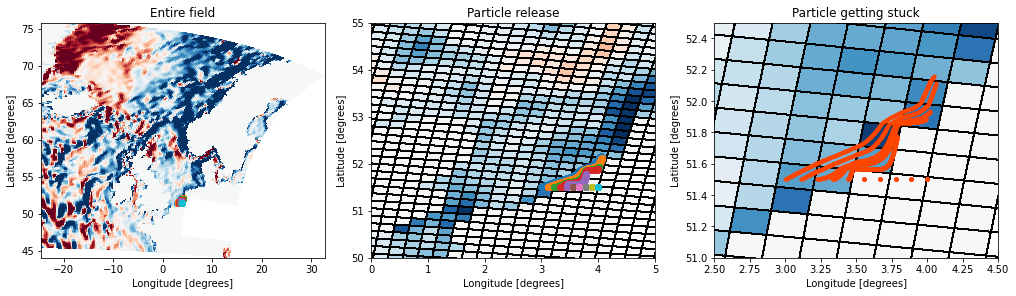

In [12]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,4),constrained_layout=True)

ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_title('Entire field')

ax1.pcolormesh(coords['glamf'][0],coords['gphif'][0],cvfields['vo'][0,0,1:,1:], cmap='RdBu', vmin=-0.1, vmax=0.1)
ax1.plot(data['lon'].T, data['lat'].T,marker='o',linewidth=3)

ax2.set_ylabel('Latitude [degrees]')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_title('Particle release')
ax2.set_xlim(0, 5)
ax2.set_ylim(50, 55)

ax2.pcolormesh(coords['glamf'][0],coords['gphif'][0],cvfields['vo'][0,0,1:,1:], cmap='RdBu', vmin=-0.1, vmax=0.1, edgecolors='k',linewidth=1)
ax2.plot(data['lon'].T, data['lat'].T,marker='o',linewidth=3)

ax3.set_ylabel('Latitude [degrees]')
ax3.set_xlabel('Longitude [degrees]')
ax3.set_title('Particle getting stuck')
ax3.set_xlim(2.5, 4.5)
ax3.set_ylim(51, 52.5)

ax3.pcolormesh(coords['glamf'][0],coords['gphif'][0],cvfields['vo'][0,0,1:,1:], cmap='RdBu', vmin=-0.1, vmax=0.1,edgecolors='k',linewidth=1)
ax3.plot(data['lon'].T, data['lat'].T,marker='o',markersize=3, c='orangered')

plt.show()

The free-slip or partial-slip boundary results in a tangential flow along the boundary.

## Boundary solutions

### Flag on land cells

### Parabolic profile

To be consistent with physics, where the flow becomes tangential near the boundary, as well as consistent with C-grid computational grids that are interpolated to A grids, different profiles can be imposed near the solid-fluid boundaries, that make the ratio of tangential to normal velocities go to infinity, so that particles move tangentially along the boundaries. This happens when a parabolic profile is imposed for the normal component and a linear profile is imposed for the tangential velocity. To implement this in a Parcels kernel we need to do the following:

1. Find 'cells' with a solid-fluid boundary
2. Find the direction of the boundary and map this
3. Write a kernel-particle combination that samples this boundary direction and moves according to the profile

From a masked array where the fluid is 0 and the solid is 1 we can find the cells on the edge of the solid. By checking where these cells are next to fluid cells we can map the direction of the boundary. Because the sampling kernel will use nearest neighbour interpolation, we want to store the boundary directions at the centers of the gridcells. Depending on the model, this can be at the nodes or shifted 0.5 dx and 0.5 dy (and 0.5 dz). 

In [13]:
def map_coastal_cells(u_masked):
    '''
    Coastmask
    Create a mask in which only the object cells bordering a fluid cell are masked
    The solid domain is masked in the flow.
    By removing those masked cells that are surrounded on all sides by other masked cells
    the remaining mask contains only the object cells bordering the fluid.
    ''' 

    coastal_cells=np.copy(u_masked.mask)
    
    for i in range(len(u_masked)):
        for j in range(len(u_masked[i])):
            
            if u_masked.mask[i,j] == True:
                
                if i>0 and i<len(u_masked)-1 and j>0 and j<len(u_masked[i])-1:
                    if u_masked.mask[i-1,j]==True and u_masked.mask[i+1,j]==True and u_masked.mask[i,j-1]==True and u_masked.mask[i,j+1]==True:
                        coastal_cells[i, j]=False
                elif i==0 and j>0 and j<len(u_masked[i])-1:
                    if u_masked.mask[i+1,j]==True and u_masked.mask[i,j-1]==True and u_masked.mask[i,j+1]==True:
                        coastal_cells[i, j]=False
                elif i==len(u_masked)-1 and j>0 and j<len(u_masked[i])-1:
                    if u_masked.mask[i-1,j]==True and u_masked.mask[i,j-1]==True and u_masked.mask[i,j+1]==True:
                        coastal_cells[i, j]=False
                elif i>0 and i<len(u_masked)-1 and j==0:
                    if u_masked.mask[i-1,j]==True and u_masked.mask[i+1,j]==True and u_masked.mask[i,j+1]==True:
                        coastal_cells[i, j]=False
                elif i>0 and i<len(u_masked)-1 and j==len(u_masked[i])-1:
                    if u_masked.mask[i-1,j]==True and u_masked.mask[i+1,j]==True and u_masked.mask[i,j-1]==True:
                        coastal_cells[i, j]=False
                elif i==0 and j==0:
                    if u_masked.mask[i+1,j]==True and u_masked.mask[i,j+1]==True:
                        coastal_cells[i, j]=False
                elif i==0 and j==len(u_masked[i])-1:
                    if u_masked.mask[i+1,j]==True and u_masked.mask[i,j-1]==True:
                        coastal_cells[i, j]=False
                elif i==len(u_masked)-1 and j==0:
                    if u_masked.mask[i-1,j]==True and u_masked.mask[i,j+1]==True:
                        coastal_cells[i, j]=False
                elif i==len(u_masked)-1 and j==len(u_masked[i])-1:
                    if u_masked.mask[i-1,j]==True and u_masked.mask[i,j-1]==True:
                        coastal_cells[i, j]=False
    return coastal_cells

In [14]:
def map_boundary_directions(coastal_cells):
    '''
    This function takes the cells that form the edges of the solid and checks for each cell in the domain if one of those coastal cells is above, below, left or right.
    The direction is stored in the boundarymap variable with different powers of two associated to each direction.
    '''
    boundarymap = np.zeros(coastal_cells.shape)
    for i in range(len(coastal_cells)):
        for j in range(len(coastal_cells[i])):
            if i > 0 and i < len(coastal_cells) - 1 and j > 0 and j < len(coastal_cells[i]) - 1:
                if coastal_cells[i - 1, j] == True:
                    boundarymap[i,j] += 1           # boundary below
                if coastal_cells[i + 1, j] == True:
                    boundarymap[i,j] += 2           # boundary above
                if coastal_cells[i, j - 1] == True:
                    boundarymap[i,j] += 4           # boundary left
                if coastal_cells[i, j + 1] == True:
                    boundarymap[i, j] += 8          # boundary right
            elif i == 0 and j > 0 and j < len(coastal_cells[i]) - 1:
                if coastal_cells[i + 1, j] == True:
                    boundarymap[i,j] += 2
                if coastal_cells[i, j - 1] == True:
                    boundarymap[i,j] += 4
                if coastal_cells[i, j + 1] == True:
                    boundarymap[i,j] += 8
            elif i == len(coastal_cells) - 1 and j > 0 and j < len(coastal_cells[i]) - 1:
                if coastal_cells[i - 1, j] == True:
                    boundarymap[i,j] += 1
                if coastal_cells[i, j - 1] == True:
                    boundarymap[i,j] += 4
                if coastal_cells[i, j + 1] == True:
                    boundarymap[i,j] += 8
            elif i > 0 and i < len(coastal_cells) - 1 and j == 0:
                if coastal_cells[i - 1, j] == True:
                    boundarymap[i,j] += 1
                if coastal_cells[i + 1, j] == True:
                    boundarymap[i,j] += 2
                if coastal_cells[i, j + 1] == True:
                    boundarymap[i,j] += 8
            elif i > 0 and i < len(coastal_cells) - 1 and j == len(coastal_cells[i]) - 1:
                if coastal_cells[i - 1, j] == True:
                    boundarymap[i,j] += 1
                if coastal_cells[i + 1, j] == True:
                    boundarymap[i,j] += 2
                if coastal_cells[i, j - 1] == True:
                    boundarymap[i, j] += 4
            elif i == 0 and j == 0:
                if coastal_cells[i + 1, j] == True:
                    boundarymap[i,j] += 2
                if coastal_cells[i, j + 1] == True:
                    boundarymap[i, j] += 8
            elif i == 0 and j == len(coastal_cells[i]) - 1:
                if coastal_cells[i + 1, j] == True:
                    boundarymap[i,j] += 2
                if coastal_cells[i, j - 1] == True:
                    boundarymap[i, j] += 4
            elif i == len(coastal_cells) - 1 and j == 0:
                if coastal_cells[i - 1, j] == True:
                    boundarymap += 1
                if coastal_cells[i, j + 1] == True:
                    boundarymap[i, j] += 8
            elif i == len(coastal_cells) - 1 and j == len(coastal_cells[i]) - 1:
                if coastal_cells[i - 1, j] == True:
                    boundarymap[i,j] += 1
                if coastal_cells[i, j - 1] == True:
                    boundarymap[i, j] += 4
    return boundarymap

#### Neumann boundary profile
First let's look at the case where the nodes are located at the center of the gridcells and a Neumann boundary condition defines the boundary in the middle between two nodes as in **figure 1B**.

In [15]:
flowdata = xr.open_dataset(Peninsula_file)
dx = np.abs(flowdata['x'][1]-flowdata['x'][0])
dy = dx

umask = np.ma.masked_values(flowdata['vozocrtx'][0,0], 0) # masking the coral objects, where the velocity is NaN
x,y = np.meshgrid(flowdata['x'],flowdata['y'])
x_corners,y_corners = np.meshgrid(np.linspace(flowdata['x'].values[0]-0.5*dx, flowdata['x'].values[-1]+0.5*dx, len(flowdata['x'])+1),
                np.linspace(flowdata['y'].values[0]-0.5*dy, flowdata['y'].values[-1]+0.5*dy, len(flowdata['y'])+1))

In this case the mask that defines which cells are solid can simply be made from the velocity field. The boundary directions need to be stored at the centers of grid cells and these coincide with the velocity nodes in this case.

In [16]:
if _check_file_exist('peninsula_coast.npy'):
    coastalmap = np.load('peninsula_coast.npy')
else:
    coastalmap = map_coastal_cells(umask)
    np.save('peninsula_coast.npy', coastalmap, allow_pickle=True)

In [17]:
if _check_file_exist('peninsula_boundaries.npy'):
    boundarymap = np.load('peninsula_boundaries.npy')
else:
    boundarymap = map_boundary_directions(coastalmap)
    np.save('peninsula_boundaries.npy', boundarymap, allow_pickle=True)

Here we look at the resulting fields calculated by the algorithms. From the solid cells as defined by the mask, the edges are mapped in the `coastalmap`. From there the boundary directions are calculated.

(0.0, 20000.0)

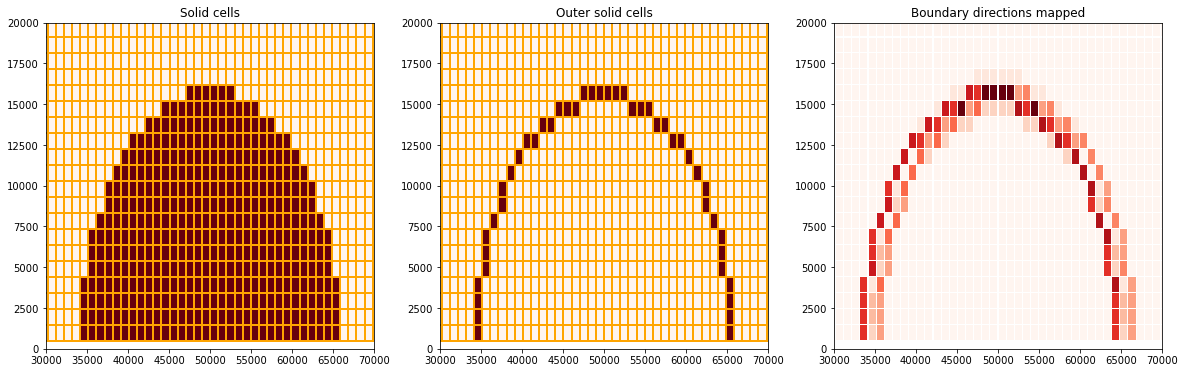

In [18]:
fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,6))

ax1.set_title('Solid cells')
ax1.pcolormesh(x_corners, y_corners,umask.mask,cmap='Reds',edgecolor='orange')
ax1.set_xlim(30000,70000)
ax1.set_ylim(0,20000)

ax2.set_title('Outer solid cells')
ax2.pcolormesh(x_corners, y_corners, coastalmap ,cmap='Reds',edgecolor='orange')
ax2.set_xlim(30000,70000)
ax2.set_ylim(0,20000)

ax3.set_title('Boundary directions mapped')
ax3.pcolormesh(x_corners, y_corners, boundarymap, cmap='Reds', edgecolor='w', lw=0.1)
ax3.set_xlim(30000,70000)
ax3.set_ylim(0,20000)

During the Parcels simulation the particles need to 'know' where the boundary is. They do this by sampling the boundarymap `Field` and storing the value in a `Variable` called `'boundary'`.

In [19]:
class BoundaryParticle(JITParticle):  # Define a new particle class that is aware of the solid-fluid boundaries
    boundary = Variable('boundary', dtype=np.float32, initial=0.)

The advection kernel below imposes a profile near solid-fluid boundaries by taking the direction of the nearest boundary and multiplying the velocity found by Parcels with a factor that depends on the distance to the boundary. To find the distance to the boundary, the particle coordinate in the direction of the boundary is rewritten in terms of the number of cells from the origin, e.g. for a boundary in the x-direction: 
```
lon_cell = (particle.lon - fieldset.x0 + 0.5 * fieldset.dx) / fieldset.dx
```
If the particle is in the 8th cell from the origin in the x-direction `lon_cell` will be `8.7` for example. By substracting the `math.floor(lon_cell) = 8`, we find the relative position in the cell: `0.7`. If the boundary is on the right side of the cell this means that the particle is `0.3 dx` from the boundary. According to this distance a linear profile is imposed for the tangential velocity and a parabolic profile for the normal velocity. Both go to zero at the boundary. This kernel only works with regular grids in which the relative position in the cell can be calculated from x0 and dx.

In [20]:
def AdvectionRK4_2D_ParabolicBoundary(particle, fieldset, time):
    """Advection of particles using fourth-order Runge-Kutta integration.

    Adapted from Parcels code, this Kernel interpolates the velocities differently close to solid objects.

    Needs to be used in combination with the BoundaryParticle class to access boundary directions in particle.boundary

    Only works on regular grids where the location within a grid cell can be found with the coordinate origin (x0, y0) and dx and dy"""

    (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    lon1 = particle.lon + u1 * .5 * particle.dt
    lat1 = particle.lat + v1 * .5 * particle.dt
    (u2, v2) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat1, lon1]
    lon2 = particle.lon + u2 * .5 * particle.dt
    lat2 = particle.lat + v2 * .5 * particle.dt
    (u3, v3) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat2, lon2]
    lon3 = particle.lon + u3 * particle.dt
    lat3 = particle.lat + v3 * particle.dt
    (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3]

    # Determine final velocities to be checked against the directions of the boundaries
    u_final = (u1 + 2 * u2 + 2 * u3 + u4) / 6.
    v_final = (v1 + 2 * v2 + 2 * v3 + v4) / 6.

    B_binary = particle.boundary # do not change particle.boundary in this kernel
    n_boundary = 0               # counter to keep track of the amount of boundarys

    f_u = 1
    lon_cell = (particle.lon - fieldset.x0 + 0.5 * fieldset.dx) / fieldset.dx
    lon_frac = lon_cell - math.floor(lon_cell)
    f_v = 1
    lat_cell = (particle.lat - fieldset.y0 + 0.5 * fieldset.dy) / fieldset.dy
    lat_frac = lat_cell - math.floor(lat_cell)

    if B_binary >= 8:  # boundary right
        B_binary += -8
        if lon_frac > 0.5:
            f_u = 4 * math.pow(1 - lon_frac, 2)  # no cross-boundary movement
            f_v = 2 - 2 * lon_frac
            n_boundary += 1
    if B_binary >= 4:  # boundary left
        B_binary += -4
        if lon_frac < 0.5 and n_boundary == 0:
            f_u = 4 * math.pow(lon_frac, 2)
            f_v = 2 * lon_frac
            n_boundary += 1
    if B_binary >= 2:  # boundary below
        B_binary += -2
        if lat_frac > 0.5 and n_boundary == 0:
            f_u = 2 - 2 * lat_frac
            f_v = 4 * math.pow(1 - lat_frac, 2)
            n_boundary += 1
        elif lat_frac > 0.5 and particle.boundary > 8:
            if lon_frac - lat_frac < 0:
                f_u = 2 - 2 * lat_frac
                f_v = 4 * math.pow(1 - lat_frac, 2)
                n_boundary += 1
            elif lon_frac - lat_frac > 0:
                f_u = 4 * math.pow(1 - lon_frac, 2)
                f_v = 2 - 2 * lon_frac
                n_boundary += 1
        elif lat_frac > 0.5 and particle.boundary > 4:
            if lon_frac + lat_frac > 1:
                f_u = 2 - 2 * lat_frac
                f_v = 4 * math.pow(1 - lat_frac, 2)
                n_boundary += 1
            elif lon_frac + lat_frac < 1:
                f_u = 4 * math.pow(lon_frac, 2)
                f_v = 2 * lon_frac
                n_boundary += 1
    if B_binary == 1:  # boundary above
        if lat_frac < 0.5 and n_boundary == 0:
            f_u = 2 * lat_frac
            f_v = 4 * math.pow(lat_frac, 2)
            n_boundary += 1
        elif lat_frac < 0.5 and particle.boundary > 8:
            if lon_frac + lat_frac > 1:
                f_u = 4 * math.pow(1 - lon_frac, 2)
                f_v = 2 - 2 * lon_frac
                n_boundary += 1
            elif lon_frac + lat_frac < 1:
                f_u = 2 * lat_frac
                f_v = 4 * math.pow(lat_frac, 2)
                n_boundary += 1
        elif lat_frac < 0.5 and particle.boundary > 4:
            if lon_frac - lat_frac < 0:
                f_u = 4 * math.pow(lon_frac, 2)
                f_v = 2 * lon_frac
                n_boundary += 1
            elif lon_frac - lat_frac > 0:
                f_u = 2 * lat_frac
                f_v = 4 * math.pow(lat_frac, 2)
                n_boundary += 1


    particle.lon += f_u * u_final * particle.dt
    particle.lat += f_v * v_final * particle.dt

In [21]:
def Samples(particle, fieldset, time):  # Custom function that samples d2c, closestobject and border at particle location
    particle.boundary = fieldset.boundary[time, particle.depth, particle.lat, particle.lon]

In [22]:
fieldset = FieldSet.from_parcels("Peninsula_data/peninsula", allow_time_extrapolation=True)

boundary_field = Field('boundary', boundarymap, grid=fieldset.U.grid)

fieldset.add_field(boundary_field)
fieldset.boundary.interp_method = 'nearest'

fieldset.add_constant('x0',flowdata['x'][0])
fieldset.add_constant('y0',flowdata['y'][0])
fieldset.add_constant('dx', flowdata['x'][1]-flowdata['x'][0])
fieldset.add_constant('dy', flowdata['y'][1]-flowdata['y'][0])

npart = 5  # number of particles to be released
lon = 4e4 * np.ones(npart)
lat = np.linspace(11.6e3 , 13e3, npart, dtype=np.float32)
time = np.zeros(npart)

pset = ParticleSet(fieldset=fieldset, pclass=BoundaryParticle, lon=lon, lat=lat, time=time)

kernels = pset.Kernel(AdvectionRK4_2D_ParabolicBoundary) + pset.Kernel(Samples)

output_file = pset.ParticleFile(name="Agrid-parabolic-centers", outputdt=delta(minutes=5))

pset.execute(kernels, runtime=delta(hours=12), dt=delta(minutes=5),
             output_file=output_file)
output_file.close()  # export the trajectory data to a netcdf file

INFO: Compiled BoundaryParticleAdvectionRK4_2D_ParabolicBoundarySamples ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\bc140cdb611149825d001fcf83974676_0.dll


In [23]:
ds_peninsula_centers = xr.open_dataset('Agrid-parabolic-centers.nc')

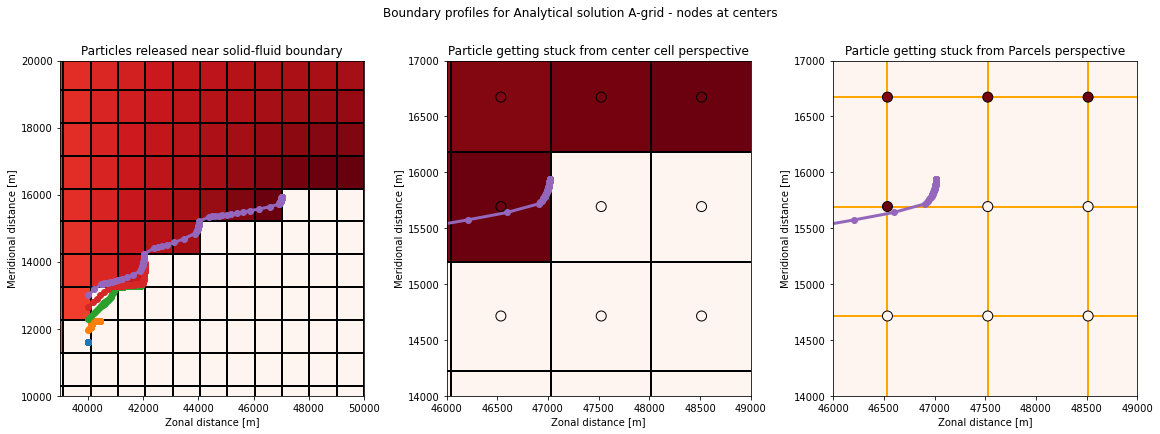

In [24]:
fig = plt.figure(figsize=(16,6), constrained_layout=True)
fig.suptitle('Boundary profiles for Analytical solution A-grid - nodes at centers')
gs = gridspec.GridSpec(ncols=3, nrows=2, height_ratios = [0.2,2], figure=fig)

ax1 = fig.add_subplot(gs[1, 0])
ax1.set_ylabel('Meridional distance [m]')
ax1.set_xlabel('Zonal distance [m]')
ax1.set_title('Particles released near solid-fluid boundary')
ax1.set_xlim(39000, 50000)
ax1.set_ylim(10000, 20000)

ax1.pcolormesh(x_corners,y_corners,flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k',linewidth=1)
ax1.plot(ds_peninsula_centers['lon'].T, ds_peninsula_centers['lat'].T,marker='o',linewidth=3)

ax2 = fig.add_subplot(gs[1, 1])
ax2.set_ylabel('Meridional distance [m]')
ax2.set_xlabel('Zonal distance [m]')
ax2.set_title('Particle getting stuck from center cell perspective')
ax2.set_xlim(46000, 49000)
ax2.set_ylim(14000, 17000)

ax2.pcolormesh(x_corners,y_corners,flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k',linewidth=1)
ax2.plot(ds_peninsula_centers['lon'].sel(traj=4), ds_peninsula_centers['lat'].sel(traj=4), c='tab:purple', linewidth=3, marker='o')
ax2.scatter(x_centers,y_centers,s=100,c=flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k')

ax3 = fig.add_subplot(gs[1, 2])
ax3.set_ylabel('Meridional distance [m]')
ax3.set_xlabel('Zonal distance [m]')
ax3.set_title('Particle getting stuck from Parcels perspective')
ax3.set_xlim(46000, 49000)
ax3.set_ylim(14000, 17000)

ax3.pcolormesh(x_centers,y_centers,cells,cmap='Reds',edgecolors='orange',linewidth=1)
ax3.scatter(x_centers,y_centers,s=100,c=flowdata['vozocrtx'][0,0],cmap='Reds', edgecolors='k')
ax3.plot(ds_peninsula_centers['lon'].sel(traj=4), ds_peninsula_centers['lat'].sel(traj=4), c='tab:purple', linewidth=3, marker='o')

#### Dirichlet boundary profile

When the velocity nodes are located at the corner of the grid cells, the centers of the cells at which the boundary directions are mapped are shifted by half a cell in each direction. A cell is then only considered a solid cell when all four nearest neighbours are part of the solid. This mask can be made by interpolating the velocities to the centers of the grid cells: where all four nearest neighbours are zero, the interpolated value will be zero and subsequently masked as a solid cell.

In [25]:
xmesh,ymesh = np.meshgrid(np.linspace(flowdata['x'].values[0]+0.5*dx, flowdata['x'].values[-1]-0.5*dx, len(flowdata['x'])-1),
                np.linspace(flowdata['y'].values[0]+0.5*dy, flowdata['y'].values[-1]-0.5*dy, len(flowdata['y'])-1))

f = interpolate.interp2d(flowdata['x'],flowdata['y'],flowdata['vozocrtx'][0,0])

u_corners = f(xmesh[0,:],ymesh[:,0])

udmask = np.ma.masked_values(u_corners, 0) # masking the coral objects, where the velocity is NaN

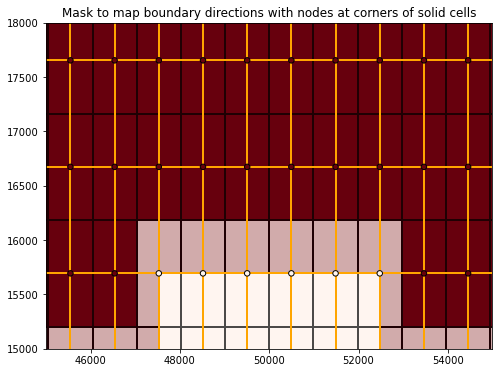

In [26]:
fig,ax = plt.subplots(figsize=(8,6))

cmap = copy(plt.get_cmap('Reds_r'))
corner_cmap = cmap(np.arange(cmap.N))
corner_cmap[:,-1] = [0.3]*cmap.N
corner_cmap = ListedColormap(corner_cmap)

ax.set_title('Mask to map boundary directions with nodes at corners of solid cells')
ax.pcolormesh(x_corners,y_corners,umask.mask,cmap='Reds_r',edgecolor='k')
ax.pcolormesh(x_centers,y_centers,udmask.mask,cmap=corner_cmap,edgecolor='orange')
ax.scatter(x_centers, y_centers, c=umask.mask, s=30, cmap='Reds_r', edgecolor='k')
ax.set_xlim(45000,55000)
ax.set_ylim(15000,18000)

custom_lines = [Line2D([0], [0],color='k'),
                Line2D([0], [0],color='orange')]

ax1.legend(custom_lines, ['Center node boundaries', 'Corner node boundaries'],loc='upper right')

In [27]:
if _check_file_exist('peninsula_coast_corners.npy'):
    coastalmap_corners = np.load('peninsula_coast_corners.npy')
else:
    coastalmap_corners = map_coastal_cells(udmask)
    np.save('peninsula_coast_corners.npy', coastalmap_corners, allow_pickle=True)

In [28]:
if _check_file_exist('peninsula_boundaries_corners.npy'):
    boundarymap_corners = np.load('peninsula_boundaries_corners.npy')
else:
    boundarymap_corners = map_boundary_directions(coastalmap_corners)
    np.save('peninsula_boundaries_corners.npy', boundarymap_corners, allow_pickle=True)

In [29]:
fieldset = FieldSet.from_parcels("Peninsula_data/peninsula", allow_time_extrapolation=True)

boundary_field = Field('boundary', boundarymap_corners, lon=xmesh[0,:], lat=ymesh[:,0])

fieldset.add_field(boundary_field)
fieldset.boundary.interp_method = 'nearest'

# Set boundary grid
fieldset.add_constant('x0', xmesh[0,0])
fieldset.add_constant('y0', ymesh[0,0])
fieldset.add_constant('dx', xmesh[0,1]-xmesh[0,0])
fieldset.add_constant('dy', ymesh[1,0]-ymesh[0,0])

npart = 5  # number of particles to be released
lon = 4e4 * np.ones(npart)
lat = np.linspace(11.6e3 , 13e3, npart, dtype=np.float32)
time = np.zeros(npart)

pset = ParticleSet(fieldset=fieldset, pclass=BoundaryParticle, lon=lon, lat=lat, time=time)

kernels = pset.Kernel(AdvectionRK4_2D_ParabolicBoundary) + pset.Kernel(Samples)

output_file = pset.ParticleFile(name="Agrid-parabolic-corners.nc", outputdt=delta(minutes=5))

pset.execute(kernels, runtime=delta(hours=12), dt=delta(minutes=5),
             output_file=output_file)
output_file.close()  # export the trajectory data to a netcdf file

INFO: Compiled BoundaryParticleAdvectionRK4_2D_ParabolicBoundarySamples ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\26217d9722f8b98ee8be2bf6ff710792_0.dll


In [30]:
ds_peninsula_corners = xr.open_dataset('Agrid-parabolic-corners.nc')

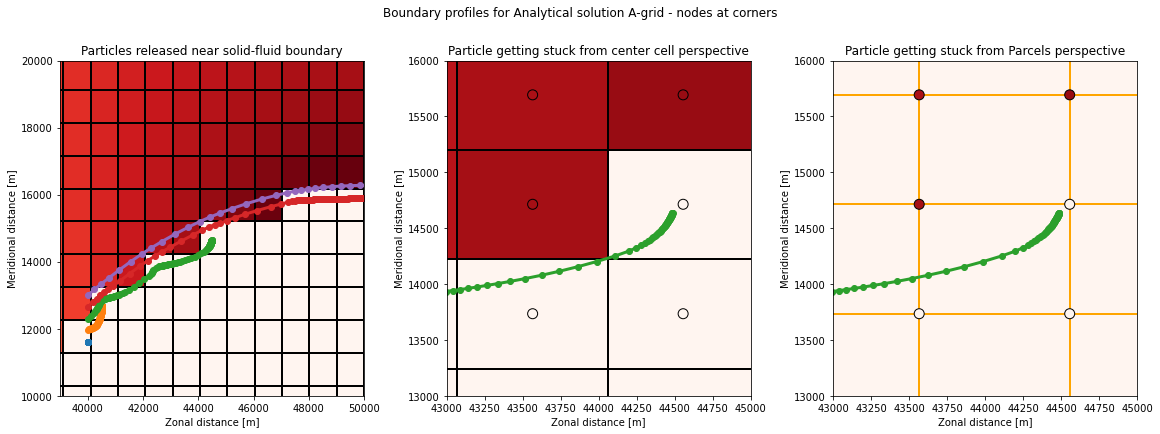

In [31]:
fig = plt.figure(figsize=(16,6), constrained_layout=True)
fig.suptitle('Boundary profiles for Analytical solution A-grid - nodes at corners')
gs = gridspec.GridSpec(ncols=3, nrows=2, height_ratios = [0.2,2], figure=fig)

ax1 = fig.add_subplot(gs[1, 0])
ax1.set_ylabel('Meridional distance [m]')
ax1.set_xlabel('Zonal distance [m]')
ax1.set_title('Particles released near solid-fluid boundary')
ax1.set_xlim(39000, 50000)
ax1.set_ylim(10000, 20000)

ax1.pcolormesh(x_corners,y_corners,flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k',linewidth=1)
ax1.plot(ds_peninsula_corners['lon'].T, ds_peninsula_corners['lat'].T,marker='o',linewidth=3)

ax2 = fig.add_subplot(gs[1, 1])
ax2.set_ylabel('Meridional distance [m]')
ax2.set_xlabel('Zonal distance [m]')
ax2.set_title('Particle getting stuck from center cell perspective')
ax2.set_xlim(43000, 45000)
ax2.set_ylim(13000, 16000)

ax2.pcolormesh(x_corners,y_corners,flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k',linewidth=1)
ax2.plot(ds_peninsula_corners['lon'].sel(traj=2), ds_peninsula_corners['lat'].sel(traj=2), c='tab:green', linewidth=3, marker='o')
ax2.scatter(x_centers,y_centers,s=100,c=flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k')

ax3 = fig.add_subplot(gs[1, 2])
ax3.set_ylabel('Meridional distance [m]')
ax3.set_xlabel('Zonal distance [m]')
ax3.set_title('Particle getting stuck from Parcels perspective')
ax3.set_xlim(43000, 45000)
ax3.set_ylim(13000, 16000)

ax3.pcolormesh(x_centers,y_centers,cells,cmap='Reds',edgecolors='orange',linewidth=1)
ax3.scatter(x_centers,y_centers,s=100,c=flowdata['vozocrtx'][0,0],cmap='Reds', edgecolors='k')
ax3.plot(ds_peninsula_corners['lon'].sel(traj=2), ds_peninsula_corners['lat'].sel(traj=2), c='tab:green', linewidth=3, marker='o')

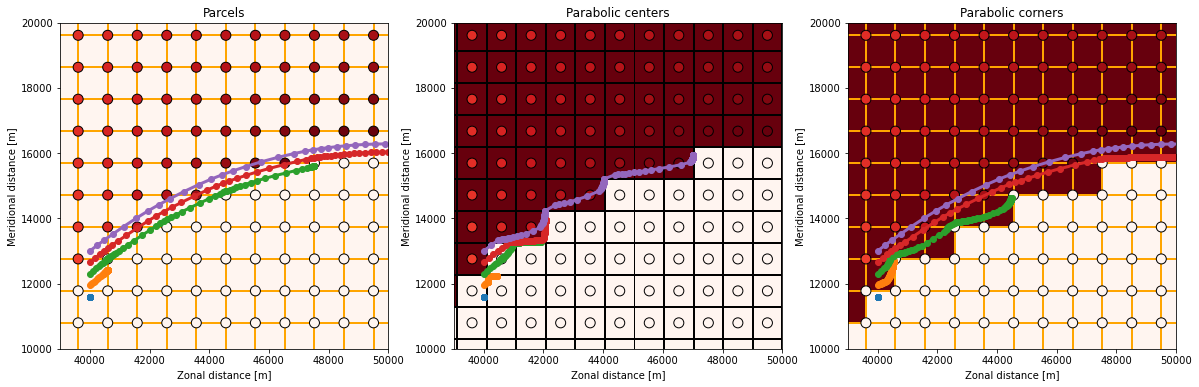

In [32]:
fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,6))

ax1.set_ylabel('Meridional distance [m]')
ax1.set_xlabel('Zonal distance [m]')
ax1.set_title('Parcels')
ax1.set_xlim(39000, 50000)
ax1.set_ylim(10000, 20000)

ax1.pcolormesh(x_centers,y_centers,cells,cmap='Reds',edgecolors='orange',linewidth=1)
ax1.scatter(x_centers,y_centers,s=100,c=flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k')
ax1.plot(ds_peninsula['lon'].T, ds_peninsula['lat'].T,marker='o',linewidth=3)

ax2.set_ylabel('Meridional distance [m]')
ax2.set_xlabel('Zonal distance [m]')
ax2.set_title('Parabolic centers')
ax2.set_xlim(39000, 50000)
ax2.set_ylim(10000, 20000)

ax2.pcolormesh(x_corners,y_corners,umask.mask,cmap='Reds_r',edgecolors='k',linewidth=1)
ax2.scatter(x_centers,y_centers,s=100,c=flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k')
ax2.plot(ds_peninsula_centers['lon'].T, ds_peninsula_centers['lat'].T,marker='o',linewidth=3)

ax3.set_ylabel('Meridional distance [m]')
ax3.set_xlabel('Zonal distance [m]')
ax3.set_title('Parabolic corners')
ax3.set_xlim(39000, 50000)
ax3.set_ylim(10000, 20000)

ax3.pcolormesh(x,y,udmask.mask,cmap='Reds_r',edgecolors='orange',linewidth=1)
ax3.scatter(x_centers,y_centers,s=100,c=flowdata['vozocrtx'][0,0],cmap='Reds',edgecolors='k')
ax3.plot(ds_peninsula_corners['lon'].T, ds_peninsula_corners['lat'].T,marker='o',linewidth=3)
plt.show()

In this case of a discretized analytical solution, none of the three options presented above are a correct interpretation of the flow along the boundary. You can see however that the different interpretations can be implemented rather nicely with the kernel.

### Interpolated A grid - SMOC

Here we show how the same process can be modelled in the [SMOC dataset](https://marine.copernicus.eu/wp-content/uploads/2019/04/Poster_SMOC_EGU2018APRIL.pdf), which results from the interpolation of a C grid onto an A grid.

In [33]:
SMOCfile = 'SMOC_20190704_R20190705.nc'
SMOCfiles = ['SMOC_20190704_R20190705.nc','SMOC_20190705_R20190706.nc','SMOC_20190706_R20190707.nc']
flowdata_SMOC = xr.open_dataset(SMOCfile)

dlon = flowdata_SMOC['longitude'][1]-flowdata_SMOC['longitude'][0]
dlat = flowdata_SMOC['latitude'][1]-flowdata_SMOC['latitude'][0]
x_corners,y_corners = np.meshgrid(np.linspace(flowdata_SMOC['longitude'].values[0]-0.5*dlon, flowdata_SMOC['longitude'].values[-1]+0.5*dlon, len(flowdata_SMOC['longitude'])+1),
                np.linspace(flowdata_SMOC['latitude'].values[0]-0.5*dlat, flowdata_SMOC['latitude'].values[-1]+0.5*dlat, len(flowdata_SMOC['latitude'])+1))
x_centers, y_centers = np.meshgrid(np.linspace(flowdata_SMOC['longitude'].values[0], flowdata_SMOC['longitude'].values[-1], len(flowdata_SMOC['longitude'])),
                np.linspace(flowdata_SMOC['latitude'].values[0], flowdata_SMOC['latitude'].values[-1],len(flowdata_SMOC['latitude'])))
cells = np.zeros((len(flowdata_SMOC['latitude'])-1,len(flowdata_SMOC['longitude'])-1))

umask = np.ma.masked_invalid(flowdata_SMOC['uo'][0,0]) # masking the coral objects, where the velocity is NaN

xmesh,ymesh = np.meshgrid(np.linspace(flowdata_SMOC['longitude'].values[0]+0.5*dlon, flowdata_SMOC['longitude'].values[-1]-0.5*dlon, len(flowdata_SMOC['longitude'])-1),
                np.linspace(flowdata_SMOC['latitude'].values[0]+0.5*dlat, flowdata_SMOC['latitude'].values[-1]-0.5*dlat, len(flowdata_SMOC['latitude'])-1))

u_zeros = np.nan_to_num(flowdata_SMOC['uo'][0,0])
f = interpolate.interp2d(flowdata_SMOC['longitude'],flowdata_SMOC['latitude'],u_zeros)

u_corners = f(xmesh[0,:],ymesh[:,0])

udmask = np.ma.masked_values(u_corners,0) # masking the coral objects, where the velocity is NaN

lonminx = 2100
lonmaxx = 2350
latminx = 1400
latmaxx = 1750

In [34]:
filenames = {'U': SMOCfiles,
             'V': SMOCfiles}

variables = {'U': 'uo',
             'V': 'vo'}

dimensions = {'U': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'},
              'V': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'}}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

npart = 3  # number of particles to be released
lon = np.linspace(7, 7.2, npart, dtype=np.float32)
lat = np.linspace(53.45, 53.6, npart, dtype=np.float32)
lons, lats = np.meshgrid(lon,lat)
time = np.zeros(lons.size)

pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats, time=time)

kernels = pset.Kernel(AdvectionRK4)

output_file = pset.ParticleFile(name="SMOC.nc", outputdt=delta(hours=1))

pset.execute(kernels, runtime=delta(hours=70), dt=delta(minutes=12),
             output_file=output_file)
output_file.close()  # export the trajectory data to a netcdf file

INFO: Compiled JITParticleAdvectionRK4 ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\65ffce1140f95afea85094b4e6377740_0.dll
INFO: Temporary output files are stored in out-UIRBBVUM.
INFO: You can use "parcels_convert_npydir_to_netcdf out-UIRBBVUM" to convert these to a NetCDF file during the run.
100% (252000.0 of 252000.0) |############| Elapsed Time: 0:00:52 Time:  0:00:52


In [35]:
ds_SMOC = xr.open_dataset('SMOC.nc')

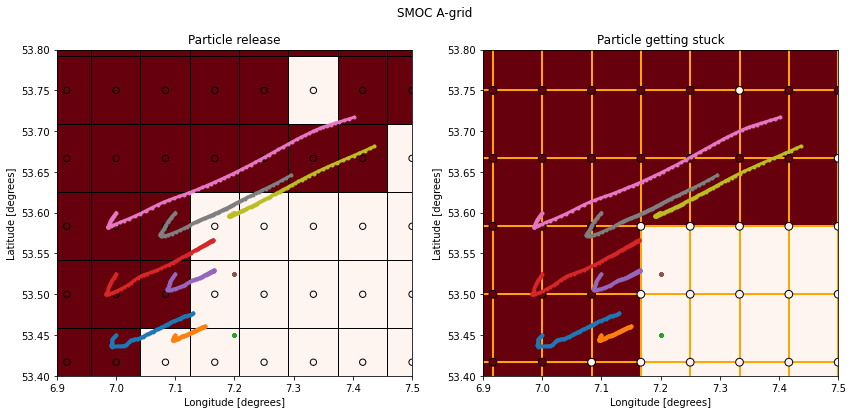

In [36]:
fig = plt.figure(figsize=(14,6))
fig.suptitle('SMOC A-grid')
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
       
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_title('Particle release')
ax1.set_xlim(6.9, 7.5)
ax1.set_ylim(53.4, 53.8)

ax1.pcolormesh(x_corners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_corners[latminx:latmaxx+1,lonminx:lonmaxx+1],umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k',linewidth=0.1)
ax1.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=40,c=umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k')
ax1.plot(ds_SMOC['lon'].T, ds_SMOC['lat'].T,marker='o',markersize=3,linewidth=3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_ylabel('Latitude [degrees]')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_title('Particle getting stuck')
ax2.set_xlim(6.9, 7.5)
ax2.set_ylim(53.4, 53.8)

ax2.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange',linewidth=1)
ax2.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=60,c=umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k')
ax2.plot(ds_SMOC['lon'].T, ds_SMOC['lat'].T,linewidth=3,marker='o',markersize=3)

plt.show()

In [37]:
if _check_file_exist('SMOC_coast.npy'):
    coastalmap = np.load('SMOC_coast.npy')
else:
    coastalmap = map_coastal_cells(umask)
    np.save('SMOC_coast.npy', coastalmap, allow_pickle=True)

In [38]:
if _check_file_exist('SMOC_boundaries.npy'):
    boundarymap = np.load('SMOC_boundaries.npy')
else:
    boundarymap = map_boundary_directions(coastalmap)
    np.save('SMOC_boundaries.npy', boundarymap, allow_pickle=True)

In [39]:
filenames = {'U': SMOCfiles,
             'V': SMOCfiles}

variables = {'U': 'uo',
             'V': 'vo'}

dimensions = {'U': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'},
              'V': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'}}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

boundary_field = Field('boundary', boundarymap, lon=x_centers[0,:], lat=y_centers[:,0])

fieldset.add_field(boundary_field)
fieldset.boundary.interp_method = 'nearest'

# Set boundary grid
fieldset.add_constant('x0',x_centers[0,0])
fieldset.add_constant('y0',y_centers[0,0])
fieldset.add_constant('dx', x_centers[0,1]-x_centers[0,0])
fieldset.add_constant('dy', y_centers[1,0]-y_centers[0,0])

npart = 3  # number of particles to be released
lon = np.linspace(7, 7.2, npart, dtype=np.float32)
lat = np.linspace(53.45, 53.6, npart, dtype=np.float32)
lons, lats = np.meshgrid(lon,lat)
time = np.zeros(lons.size)

pset = ParticleSet(fieldset=fieldset, pclass=BoundaryParticle, lon=lons, lat=lats, time=time)

kernels = pset.Kernel(AdvectionRK4_2D_ParabolicBoundary) + pset.Kernel(Samples)

output_file = pset.ParticleFile(name="SMOC-parabolic-centers.nc", outputdt=delta(hours=1))

pset.execute(kernels, runtime=delta(hours=70), dt=delta(minutes=5),
             output_file=output_file)
output_file.close()  # export the trajectory data to a netcdf file

INFO: Compiled BoundaryParticleAdvectionRK4_2D_ParabolicBoundarySamples ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\f8a53dcca42118ab25f5e06cbec461b1_0.dll
INFO: Temporary output files are stored in out-PHEOBPAR.
INFO: You can use "parcels_convert_npydir_to_netcdf out-PHEOBPAR" to convert these to a NetCDF file during the run.
100% (252000.0 of 252000.0) |############| Elapsed Time: 0:00:54 Time:  0:00:54


In [40]:
ds_SMOC_centers = xr.open_dataset('SMOC-parabolic-centers.nc')

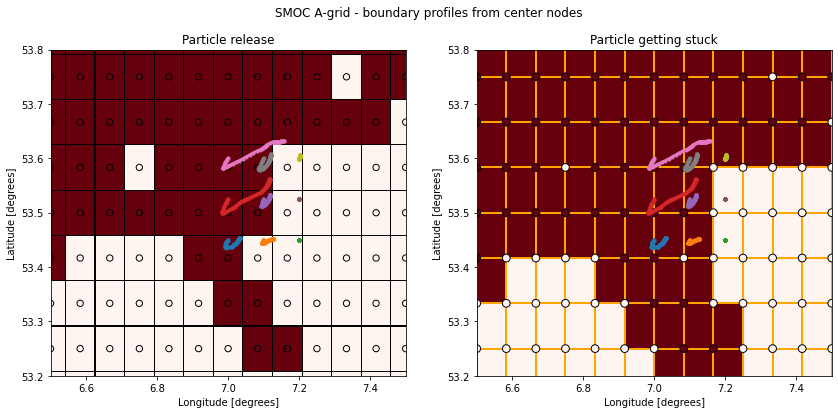

In [41]:
fig = plt.figure(figsize=(14,6))
fig.suptitle('SMOC A-grid - boundary profiles from center nodes')
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
       
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_title('Particle release')
ax1.set_xlim(6.5, 7.5)
ax1.set_ylim(53.2, 53.8)

ax1.pcolormesh(x_corners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_corners[latminx:latmaxx+1,lonminx:lonmaxx+1],umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k',linewidth=0.1)
ax1.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=40,c=umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k')
ax1.plot(ds_SMOC_centers['lon'].T, ds_SMOC_centers['lat'].T,marker='o',markersize=3,linewidth=3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_ylabel('Latitude [degrees]')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_title('Particle getting stuck')
ax2.set_xlim(6.5, 7.5)
ax2.set_ylim(53.2, 53.8)

ax2.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange',linewidth=1)
ax2.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=60,c=umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k')
ax2.plot(ds_SMOC_centers['lon'].T, ds_SMOC_centers['lat'].T,linewidth=3,marker='o',markersize=3)


In [42]:
if _check_file_exist('SMOC_coast_corners.npy'):
    coastalmap_corners = np.load('SMOC_coast_corners.npy')
else:
    coastalmap_corners = map_coastal_cells(udmask)
    np.save('SMOC_coast_corners.npy', coastalmap_corners, allow_pickle=True)

In [43]:
if _check_file_exist('SMOC_boundaries_corners.npy'):
    boundarymap_corners = np.load('SMOC_boundaries_corners.npy')
else:
    boundarymap_corners = map_boundary_directions(coastalmap_corners)
    np.save('SMOC_boundaries_corners.npy', boundarymap_corners, allow_pickle=True)

In [44]:
filenames = {'U': SMOCfiles,
             'V': SMOCfiles}

variables = {'U': 'uo',
             'V': 'vo'}

dimensions = {'U': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'},
              'V': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'depth', 'time': 'time'}}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

boundary_field = Field('boundary', boundarymap_corners, lon=xmesh[0,:], lat=ymesh[:,0])

fieldset.add_field(boundary_field)
fieldset.boundary.interp_method = 'nearest'

# Set boundary grid
fieldset.add_constant('x0',xmesh[0,0])
fieldset.add_constant('y0',ymesh[0,0])
fieldset.add_constant('dx', xmesh[0,1]-xmesh[0,0])
fieldset.add_constant('dy', ymesh[1,0]-ymesh[0,0])

npart = 3  # number of particles to be released
lon = np.linspace(7, 7.2, npart, dtype=np.float32)
lat = np.linspace(53.45, 53.6, npart, dtype=np.float32)
lons, lats = np.meshgrid(lon,lat)
time = np.zeros(lons.size)

pset = ParticleSet(fieldset=fieldset, pclass=BoundaryParticle, lon=lons, lat=lats, time=time)

kernels = pset.Kernel(AdvectionRK4_2D_ParabolicBoundary) + pset.Kernel(Samples)

output_file = pset.ParticleFile(name="SMOC-parabolic-corners.nc", outputdt=delta(hours=1))

pset.execute(kernels, runtime=delta(hours=70), dt=delta(minutes=12),
             output_file=output_file)
output_file.close()  # export the trajectory data to a netcdf file

INFO: Compiled BoundaryParticleAdvectionRK4_2D_ParabolicBoundarySamples ==> C:\Users\GEBRUI~1\AppData\Local\Temp\parcels-tmp\6c1a1a61deba4e07ee339c9af72a51ea_0.dll
INFO: Temporary output files are stored in out-PDJEMNPK.
INFO: You can use "parcels_convert_npydir_to_netcdf out-PDJEMNPK" to convert these to a NetCDF file during the run.
100% (252000.0 of 252000.0) |############| Elapsed Time: 0:00:54 Time:  0:00:54


In [45]:
ds_SMOC_corners = xr.open_dataset('SMOC-parabolic-corners.nc')

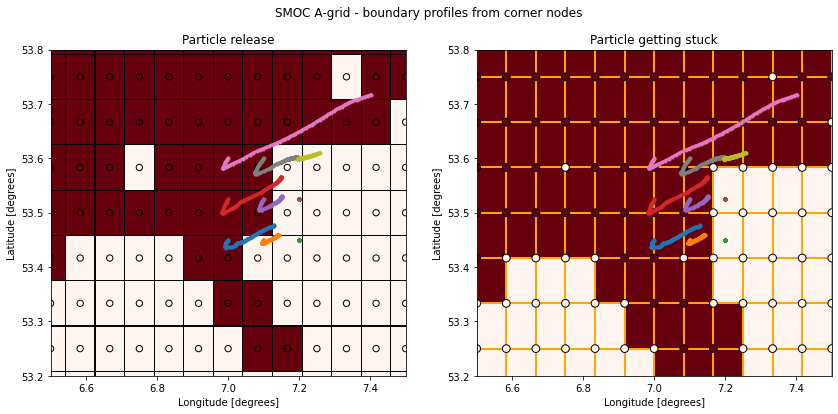

In [46]:
fig = plt.figure(1, figsize=(14,6))
fig.suptitle('SMOC A-grid - boundary profiles from corner nodes')
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
       
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_title('Particle release')
ax1.set_xlim(6.5, 7.5)
ax1.set_ylim(53.2, 53.8)

ax1.pcolormesh(x_corners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_corners[latminx:latmaxx+1,lonminx:lonmaxx+1],umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k',linewidth=0.1)
ax1.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=40,c=umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k')
ax1.plot(ds_SMOC_corners['lon'].T, ds_SMOC_corners['lat'].T,marker='o',markersize=3,linewidth=3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_ylabel('Latitude [degrees]')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_title('Particle getting stuck')
ax2.set_xlim(6.5, 7.5)
ax2.set_ylim(53.2, 53.8)

ax2.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange',linewidth=1)
ax2.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=60,c=umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k')
ax2.plot(ds_SMOC_corners['lon'].T, ds_SMOC_corners['lat'].T,linewidth=3,marker='o',markersize=3)

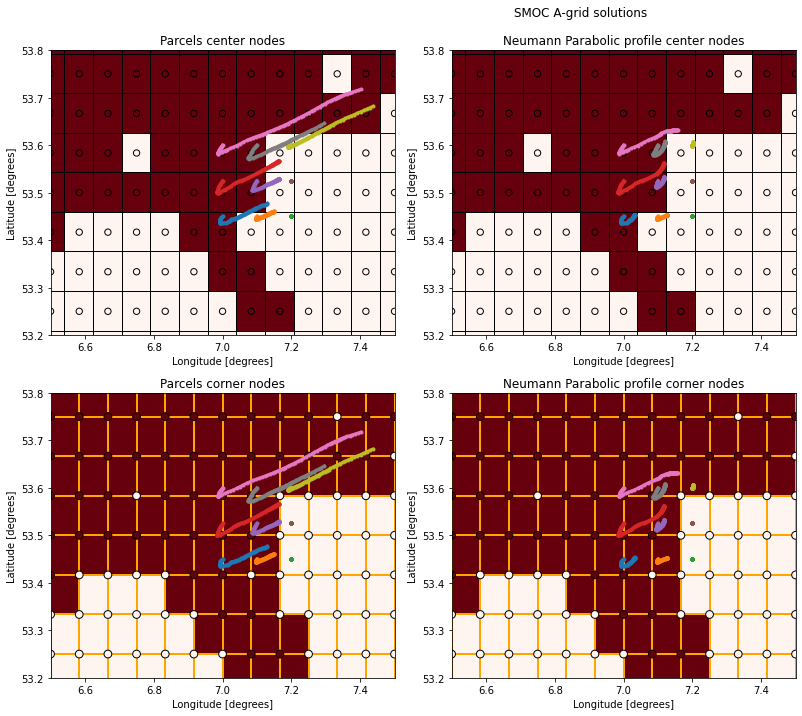

C:\Users\Gebruiker\anaconda3\envs\py3_parcels\lib\site-packages\ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\Users\Gebruiker\anaconda3\envs\py3_parcels\lib\site-packages\ipykernel_launcher.py:61: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [47]:
fig = plt.figure(2, figsize=(16,10),constrained_layout=True)
fig.suptitle('SMOC A-grid solutions')
gs = gridspec.GridSpec(ncols=3, nrows=3, height_ratios=[0.2,2,2], figure=fig)

ax1 = fig.add_subplot(gs[1, 0])
ax1.set_ylabel('Latitude [degrees]')
ax1.set_xlabel('Longitude [degrees]')
ax1.set_title('Parcels center nodes')
ax1.set_xlim(6.5, 7.5)
ax1.set_ylim(53.2, 53.8)

ax1.pcolormesh(x_corners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_corners[latminx:latmaxx+1,lonminx:lonmaxx+1],umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k',linewidth=0.1)
ax1.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=40,c=umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k')
ax1.plot(ds_SMOC['lon'].T, ds_SMOC['lat'].T,marker='o',markersize=3,linewidth=3)

ax2 = fig.add_subplot(gs[2, 0])
ax2.set_ylabel('Latitude [degrees]')
ax2.set_xlabel('Longitude [degrees]')
ax2.set_title('Parcels corner nodes')
ax2.set_xlim(6.5, 7.5)
ax2.set_ylim(53.2, 53.8)

ax2.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange',linewidth=1)
ax2.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=60,c=umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k')
ax2.plot(ds_SMOC['lon'].T, ds_SMOC['lat'].T,linewidth=3,marker='o',markersize=3)

ax3 = fig.add_subplot(gs[1, 1])
ax3.set_ylabel('Latitude [degrees]')
ax3.set_xlabel('Longitude [degrees]')
ax3.set_title('Neumann Parabolic profile center nodes')
ax3.set_xlim(6.5, 7.5)
ax3.set_ylim(53.2, 53.8)

ax3.pcolormesh(x_corners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_corners[latminx:latmaxx+1,lonminx:lonmaxx+1],umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k',linewidth=0.1)
ax3.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=40,c=umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k')
ax3.plot(ds_SMOC_centers['lon'].T, ds_SMOC_centers['lat'].T,marker='o',markersize=3,linewidth=3)

ax4 = fig.add_subplot(gs[2, 1])
ax4.set_ylabel('Latitude [degrees]')
ax4.set_xlabel('Longitude [degrees]')
ax4.set_title('Neumann Parabolic profile corner nodes')
ax4.set_xlim(6.5, 7.5)
ax4.set_ylim(53.2, 53.8)

ax4.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange',linewidth=1)
ax4.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=60,c=umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k')
ax4.plot(ds_SMOC_centers['lon'].T, ds_SMOC_centers['lat'].T,linewidth=3,marker='o',markersize=3)
plt.show()

ax5 = fig.add_subplot(gs[1, 2])
ax5.set_ylabel('Latitude [degrees]')
ax5.set_xlabel('Longitude [degrees]')
ax5.set_title('Dirichlet Parabolic profile center nodes')
ax5.set_xlim(6.5, 7.5)
ax5.set_ylim(53.2, 53.8)

ax5.pcolormesh(x_corners[latminx:latmaxx+1,lonminx:lonmaxx+1],y_corners[latminx:latmaxx+1,lonminx:lonmaxx+1],umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k',linewidth=0.1)
ax5.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=40,c=umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k')
ax5.plot(ds_SMOC_corners['lon'].T, ds_SMOC_corners['lat'].T,marker='o',markersize=3,linewidth=3)

ax6 = fig.add_subplot(gs[2, 2])
ax6.set_ylabel('Latitude [degrees]')
ax6.set_xlabel('Longitude [degrees]')
ax6.set_title('Dirichlet Parabolic profile corner nodes')
ax6.set_xlim(6.5, 7.5)
ax6.set_ylim(53.2, 53.8)

ax6.pcolormesh(x_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],y_centers[latminx:latmaxx+1,lonminx:lonmaxx+1],udmask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='orange',linewidth=1)
ax6.scatter(x_centers[latminx:latmaxx,lonminx:lonmaxx],y_centers[latminx:latmaxx,lonminx:lonmaxx],s=60,c=umask.mask[latminx:latmaxx,lonminx:lonmaxx],cmap='Reds_r',edgecolors='k')
ax6.plot(ds_SMOC_corners['lon'].T, ds_SMOC_corners['lat'].T,linewidth=3,marker='o',markersize=3)
plt.show()

### Nudging steps

### Stochastic beaching

## Benchmarking

## References

Cushman-Roisin, B., & Jean-Marie, B. (2011). Introduction to Geophysical Fluid Dynamics: Physical and Numerical Aspects (p. 789).

Lynch, D. R., Greenberg, D. A., Bilgili, A., McGillicuddy, J., Manning, J. P., & Aretxabaleta, A. L. (2015). Particles in the Coastal Ocean Theory and Applications. Cambridge University Press. https://doi.org/10.1017/CBO9781107449336
